# Machine Learning Final Project
## Real or Not? NLP with Disaster Tweets
## Analysis by Kyla Ronellenfitsch 
## Fall 2020

This project is based on the Kaggle competition of the same title. The objective is to build a machine learning model that predicts which Tweets are about real disasters and which ones aren’t. 

https://www.kaggle.com/c/nlp-getting-started/overview

In this notebook, I experiment with a variety of classification models, including: 
* Random Forest
* Support Vector Classifier
* AdaBoost Classifier
* Gradient Boosting Classifier 
* XGBoost Classifier 
* Logistic Regression 

These models were assessed individually, as well as through use of the ensemble Voting Classifier. 

Additionally, an LSTM neural network with GloVe Embeddings was also created. 

In [1238]:
#Import Relevant Packages 

# EDA and Cleaning
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.colors import ListedColormap as ListedColormap
from matplotlib import patches as mpatches
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from sklearn.decomposition import PCA, TruncatedSVD
import fuzzywuzzy
from fuzzywuzzy import process


# Modelling 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Flatten,Concatenate
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kylaronellenfitsch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
os.chdir('/Users/kylaronellenfitsch/Documents/MScA/Machine Learning')

# EDA

First begin with exploratory data analysis. 

In [613]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [8]:
print("train shape = {}".format(train_df.shape))
print("test shape = {}".format(test_df.shape))

train shape = (7613, 5)
test shape = (3263, 4)


In [614]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
y_id = test_df['id']

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [1005]:
text = train_df.text.values.tolist() #keyword data is fairly clean and worth working with 
set(text)

{"Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/1YIxFG1Hdy",
 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????',
 '@lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol',
 'Photo: Failure in structural integrity affects us all. Whether it is a barn raised upon a faulty concrete... http://t.co/cDxE5VMzOj',
 '#sing #tsunami Beginners #computer tutorial.: http://t.co/ukQYbhxMQI Everyone Wants To Learn To Build A Pc. Re http://t.co/iDWS2ZgYsa',
 'Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k',
 '@VillicanaAlicia [[Is it Darude Sandstorm?]]',
 'Chick masturbates a guy until she gets exploded on her face &gt; http://t.co/5QhoeHE9hf',
 'But the sea would..electrocute us all.',
 'LA Times: Refugio oil spill may have been costlier bigger than projected http://t.co/1ct0pUGZ69',
 "Pizza drought is over I just couldn't anymor

In [269]:
keyword = train_df.keyword.values.tolist() #keyword data is fairly clean and worth working with 
set(keyword)

{'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'de

In [270]:
location = train_df.location.values.tolist() #location dataset is a mess 
set(location)

{nan,
 'Kabul, Tuebingen, Innsbruck',
 'Cyprus',
 'Windsor,Ontario',
 'Davao City',
 'Rockford, IL',
 'Wilmington, DE',
 'Indiana, USA',
 'Western New York',
 'Kalamazoo, Michigan',
 'SEA Server',
 'Bacon',
 'Hertfordshire ',
 '[Gia.] | #KardashianEmpire',
 'NAWF SIDE POKING OUT ',
 'Florida',
 'Manchester, England',
 'At Work',
 'Glasgow, Scotland',
 'Fort Fizz, Ohio',
 'New Jersey/ D.R.',
 'Proud @BuckMasonUSA supporter!',
 'Victoria, Australia, Earth',
 'Chicora ?? Oakland',
 'Olathe, KS',
 'Lisbon, Portugal',
 'under the blanket',
 'Eagle Pass, Texas',
 'Virginia, USA',
 'central chazifornia',
 'Newton, NJ 07860',
 'Sherwood, Brisbane, Australia',
 'Phoenix Az',
 'Calgary, AB',
 'Kensington, MD',
 'Light and dark, form and void',
 'Webster, TX',
 'South of D.C.',
 'Harper Woods, MI',
 'Paterson, New Jersey ',
 'Twitter Lockout in progress',
 'Jonesboro, AR MO, IOWA USA',
 'Central Illinois',
 'Vermont, USA',
 'Erie, PA',
 "Lytham St Anne's ",
 'Portage, IN / Worldwide',
 'My old Ne

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

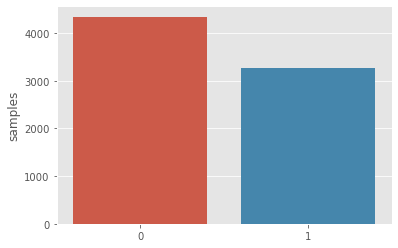

In [11]:
x=train_df.target.value_counts() #classes are unbalanced 
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [1060]:
x

0    4342
1    3271
Name: target, dtype: int64

In [1193]:
3271/4342

0.7533394748963611

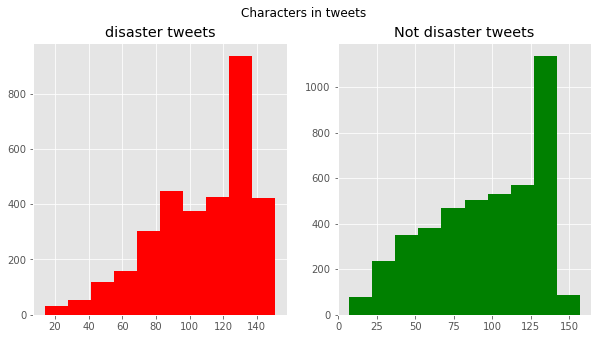

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=train_df[train_df['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

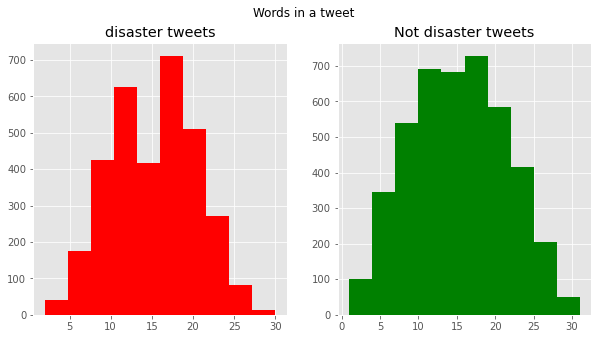

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [615]:
ag = train_df.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag.sort_values('Disaster Probability', ascending=False).head(20)

,Count,Disaster Probability
keyword,,
debris,37,1.000000
wreckage,39,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


In [616]:
ag.sort_values('Disaster Probability', ascending=True).head(20)

,Count,Disaster Probability
keyword,,
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
body%20bag,33,0.030303
electrocute,32,0.031250
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606


In [617]:
ag2 = train_df.groupby('location').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag2.sort_values('Disaster Probability', ascending=False).head(20)

,Count,Disaster Probability
location,,
,1,1.0
Melrose,1,1.0
Minneapolis - St. Paul,1,1.0
Milton/Tallahassee,1,1.0
Midwestern USA,1,1.0
Midwest,4,1.0
Middle Earth / Asgard / Berk,1,1.0
Mid north coast of NSW,1,1.0
"Miami,Fla",1,1.0


# Cleaning

### First clean the text columns 

In [769]:
#combine datasets so cleaning can be completed at once
df=pd.concat([train_df,test_df]) 
df.shape

(10876, 5)

In [22]:
#Correct spelling - this part takes a significant amount of time to run, 
#which is why the data file is saved and imported in future use 

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df['text']=df['text'].apply(lambda x : correct_spellings(x))        

In [817]:
#import cleaned data file from previous analysis 
df = pd.read_csv("cleaned_df.csv", index_col='id')

In [819]:
df = df.fillna('')
df['keyword'] = df['keyword'].astype('string')
df['location'] = df['location'].astype('string')

In [821]:
stopwords = nltk.corpus.stopwords.words("english")

def clean_txt(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    
    emoji_pattern = re.compile("[" # remove emojis
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    ## Remove URLs from a sample string
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    
    ## Remove the html in sample text
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    text =  re.sub(html, "", text)
        
     ## Remove non-ASCII characters
    l = len(text)
    t = text
    text= re.sub(r'[^\x00-\x7f]',r'', text)
        
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [822]:
df["text"] = df["text"].apply(lambda x: clean_txt(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df["keyword"] = df["keyword"].apply(lambda x: clean_txt(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df["location"] = df["location"].apply(lambda x: clean_txt(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [824]:
df['keyword'] = df['keyword'].apply(lambda x : correct_spellings(x))  
df['location'] = df['location'].apply(lambda x : correct_spellings(x))  

In [826]:
#save datafile 
df.to_csv('cleaned_df.csv')

In [849]:
#import cleaned data file from previous analysis 
df = pd.read_csv("cleaned_df.csv", index_col='id')

### Further clean location data 

In [850]:
data = df

In [855]:
data = data.fillna('')
data['keyword'] = data['keyword'].astype('string')
data['location'] = data['location'].astype('string')

In [856]:
def clean_location(data):
    # convert to lower case
    data['location'] = data['location'].str.lower()
    # remove trailing white spaces
    data['location'] = data['location'].str.strip()
    # remove comma
    data['location'] = data['location'].apply(lambda x: re.sub(r',(?s).*$', r'', x) if str(x) != str(np.nan) else np.nan)
    return data

data = clean_location(data)

In [857]:
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio >= 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [858]:
locations = data.groupby('location').location.count().sort_values(ascending=False)
locations = locations[locations.values > 3]
locations = locations.index

In [859]:
#apply function with the most common locations
for loc in locations:
    replace_matches_in_column(df=data, column='location', string_to_match=loc)

In [860]:
#manualy fusion some of them
def rename_location(data):
    data.loc[(data.location == 'united states'), 'location'] = 'usa'
    data.loc[(data.location == 'america'), 'location'] = 'usa'
    data.loc[(data.location == 'united states of america'), 'location'] = 'usa'
    data.loc[(data.location == 'us'), 'location'] = 'usa'
    data.loc[(data.location == 'u.s.'), 'location'] = 'usa'
    data.loc[(data.location == 'u.s.a'), 'location'] = 'usa'
    data.loc[(data.location == 'u.s.a.'), 'location'] = 'usa'
    data.loc[(data.location == 'new york'), 'location'] = 'nyc'
    data.loc[(data.location == 'ny'), 'location'] = 'nyc'
    data.loc[(data.location == 'new york city'), 'location'] = 'nyc'
    data.loc[(data.location == 'uk'), 'location'] = 'england'
    data.loc[(data.location == 'uk.'), 'location'] = 'england'
    data.loc[(data.location == 'united kingdom'), 'location'] = 'england'
    data.loc[(data.location == '?? | pittsburgh'), 'location'] = 'pittsburgh'
    data.loc[(data.location == '??????'), 'location'] = np.nan
    data.loc[(data.location == '?????'), 'location'] = np.nan
    data.loc[(data.location == '??'), 'location'] = np.nan
    data.loc[(data.location == 'world'), 'location'] = np.nan
    data.loc[(data.location == 'world wide'), 'location'] = np.nan
    data.loc[(data.location == 'worldwide'), 'location'] = np.nan
    data.loc[(data.location == 'everywhere'), 'location'] = np.nan
    data.loc[(data.location == 'everywhere..'), 'location'] = np.nan
    data.loc[(data.location == 'earth'), 'location'] = np.nan
    data.loc[(data.location == 'happily married with 2 kids'), 'location'] = np.nan
    data.loc[(data.location == 'road to the billionaires club'), 'location'] = np.nan
    data.loc[(data.location == 'pedophile hunting ground'), 'location'] = np.nan
    data.loc[(data.location == 'does it really matter!'), 'location'] = np.nan
    data.loc[(data.location == 'planet earth'), 'location'] = np.nan
    data.loc[(data.location == 'in the word of god'), 'location'] = np.nan
    data.loc[(data.location == 'mad as hell'), 'location'] = np.nan
    data.loc[(data.location == 'global'), 'location'] = np.nan
    data.loc[(data.location == '#global'), 'location'] = np.nan
    data.loc[(data.location == '304'), 'location'] = np.nan
    data.loc[(data.location == ''), 'location'] = np.nan
    data.loc[(data.location == 'anonymous'), 'location'] = np.nan
    data.loc[(data.location == 'breaking news'), 'location'] = np.nan
    data.loc[(data.location == 'ca'), 'location'] = np.nan
    data.loc[(data.location == 'pa'), 'location'] = np.nan
    data.loc[(data.location == 'nj'), 'location'] = 'new jersey'
    data.loc[(data.location == 'ca'), 'location'] = np.nan
    data.loc[(data.location == 'reddit'), 'location'] = np.nan
    data.loc[(data.location == 'subconscious la'), 'location'] = np.nan
    data.loc[(data.location == 'the universe'), 'location'] = np.nan
    data.loc[(data.location == 'they/them'), 'location'] = np.nan
    data.loc[(data.location == 'tx'), 'location'] = 'texas'
    data.loc[(data.location == 'your screen'), 'location'] = np.nan
    data.loc[(data.location == 'here'), 'location'] = np.nan
    data.loc[(data.location == 'iraq|afghanistan| rsa |baghdad'), 'location'] = 'baghdad'
    data.loc[(data.location == "jakarta/kuala lumpur/s'pore"), 'location'] = 'jakarta'
    data.loc[(data.location == 'nairobi-kenya'), 'location'] = 'nairobi'
    data.loc[(data.location == 'san francisco bay area'), 'location'] = 'san francisco'
    data.loc[(data.location == 'ss', 'location')] = np.nan

    
    return data

data = rename_location(data)

In [861]:
locations = data.groupby('location').location.count().sort_values(ascending=False)
locations = locations[locations.values <= 3]
locations = locations.index

#set None to locations seen less than 3 times
for loc in locations:
    data.loc[(data.location == loc), 'location'] = np.nan

In [862]:
set(data.location.values.tolist())

{'africa',
 'anchorage ak',
 'argentina',
 'arizona',
 'around world',
 'asheville nc',
 'asia',
 'atlanta',
 'atlanta ga',
 'atlanta georgia',
 'austin texas',
 'austin tx',
 'australia',
 'baltimore',
 'baltimore md',
 'bangalore',
 'bangalore india',
 'barbados',
 'baton rouge la',
 'bend oregon',
 'berlin germany',
 'birmingham',
 'boston',
 'brasil',
 'brazil',
 'brisbane',
 'brisbane australia',
 'british columbia canada',
 'brooklyn ny',
 'buffalo ny',
 'calgary',
 'calgary ab',
 'calgary alberta',
 'calgary alberta canada',
 'california',
 'california united state',
 'california usa',
 'canada',
 'cape town',
 'charlotte nc',
 'chicago',
 'chicago il',
 'chicago illinois',
 'china',
 'cleveland oh',
 'colorado',
 'columbus oh',
 'connecticut',
 'coventry',
 'dallas tx',
 'denver co',
 'denver colorado',
 'detroit mi',
 'dmv',
 'dubai',
 'dubai uae',
 'dublin ireland',
 'durham nc',
 'east coast',
 'edinburgh',
 'edmonton',
 'england',
 'europe',
 'finland',
 'florida',
 'florid

In [863]:
location2 = data.groupby('location').location.count().sort_values(ascending=False)
loc_sum = pd.DataFrame({'Disaster': [data.loc[(data.location == k) & (data.target == 1)].count()[0] for k, v in location2.items()],
                    'NotDisaster': [v for k, v in location2.items()]},
                     index=[k for k, v in location2.items()])

In [864]:
loc_sum['TotalLoc'] = loc_sum.sum(axis=1)
loc_sum['ratio'] = loc_sum['Disaster']/loc_sum.sum(axis=1)
loc_sum = loc_sum.sort_values(by=['TotalLoc'], ascending=False)

In [865]:
loc_sum

,Disaster,NotDisaster,TotalLoc,ratio
usa,72,161,233,0.154506
nyc,31,164,195,0.079487
england,25,79,104,0.120192
united state,28,68,96,0.145833
washington dc,30,59,89,0.168539
...,...,...,...,...
baltimore,0,4,4,0.000000
baton rouge la,0,4,4,0.000000
twitter,0,4,4,0.000000
rome,0,4,4,0.000000


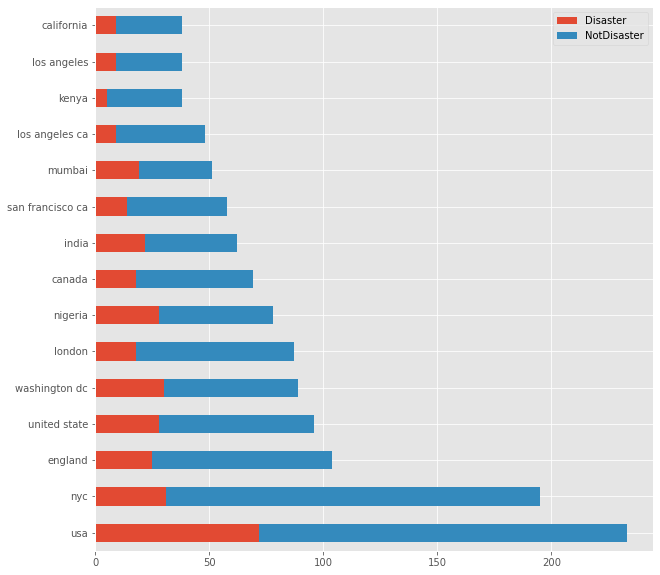

In [866]:
loc_sum[['Disaster','NotDisaster']][:15].plot.barh(figsize=(10,10), stacked=True)
plt.show()

In [873]:
df = data

In [874]:
#save datafile 
df.to_csv('cleaned_df.csv')

In [875]:
#import cleaned data file from previous analysis 
df = pd.read_csv("cleaned_df.csv", index_col='id')

# TFIDF & Machine Learning Classification Models
### Using 'text' variable only

In [1003]:
y_train = df['target']
y_train = y_train[:7613]

In [899]:
train = df.iloc[:7613]
test = df.iloc[7613:]

TF-IDF is a very popular word vectorizer used in NLP problems. It evaluates how relevant a word is to a document in a collection of documents. This is done by: 
* multiplying how many times a word appears in a document, and 
* the inverse document frequency of the word across a set of documents. 

This calculation helps to adjust for the fact that some words appear more frequently in general and prevents them from dominating. 

It is more sophisticated than a simple count vectorizer method, but does not capture semantics or position in a text, as is the case with word embeddings, sucha s GLoVe, which will be used in a later example. 

In [900]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   keyword   7552 non-null   object 
 1   location  1837 non-null   object 
 2   text      7613 non-null   object 
 3   target    7613 non-null   float64
dtypes: float64(1), object(3)
memory usage: 297.4+ KB


In [901]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   keyword   3237 non-null   object 
 1   location  796 non-null    object 
 2   text      3262 non-null   object 
 3   target    0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 127.5+ KB


In [902]:
test['text'] = test['text'].fillna(value='x')

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [912]:
vectorizer = TfidfVectorizer()
tf_train = vectorizer.fit_transform(train['text'])
tf_test = vectorizer.transform(test['text'])

In [914]:
def plot_LSA(x, y, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(x)
        lsa_scores = lsa.transform(x)
        color_mapper = {label:idx for idx,label in enumerate(set(y))}
        color_column = [color_mapper[label] for label in y]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=y, 
                        cmap=ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

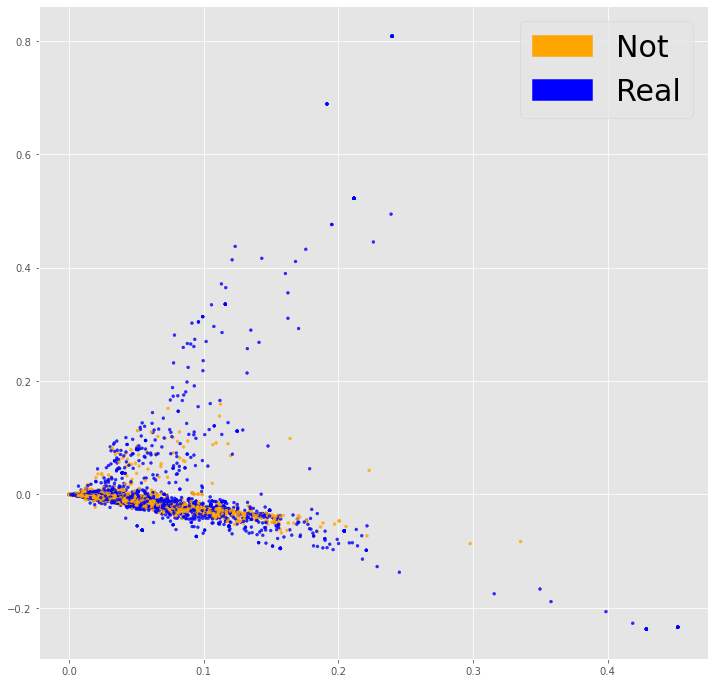

In [1004]:
fig = plt.figure(figsize=(12, 12))          
plot_LSA(tf_train, y_train)
plt.show()

In [1006]:
X_train_tf, X_valid_tf, y_train_tf, y_valid_tf = train_test_split(tf_train, train['target'].values, test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (6471, 100)
Shape of Validation  (1142, 100)


In [1008]:
print(X_train_tf.todense().shape)
print(tf_test.todense().shape)
print(X_valid_tf.todense().shape)

(6471, 15681)
(3263, 15681)
(1142, 15681)


In [1065]:
print(sum(y_train_tf))
print(sum(y_valid_tf))

2761
510


## Random Forest Classifier

In [1017]:
#create a dictionary of parameters 
param_grid = {'n_estimators':[50,100,300],
              'max_features':[2,4,6,'sqrt'],
              'max_depth':[6, 8, 10],
             }

rf = RandomForestClassifier(random_state = 12, n_jobs = -1)

# Create gridsearch object with various combinations of parameters
rf_grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 5)
rf_grid.fit(X_train_tf, y_train_tf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=12),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10],
                         'max_features': [2, 4, 6, 'sqrt'],
                         'n_estimators': [50, 100, 300]},
             scoring='roc_auc', verbose=5)

In [1018]:
print(rf_grid.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}


In [1019]:
rfbe = rf_grid.best_estimator_

In [1020]:
def report (model, x, y):
    
    pred = model.predict(x) # part b - predict class 
    
    print(classification_report(y, pred))    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, x, y, cmap = 'PuBu', ax=ax)

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      3710
           1       1.00      0.18      0.31      2761

    accuracy                           0.65      6471
   macro avg       0.81      0.59      0.54      6471
weighted avg       0.78      0.65      0.57      6471



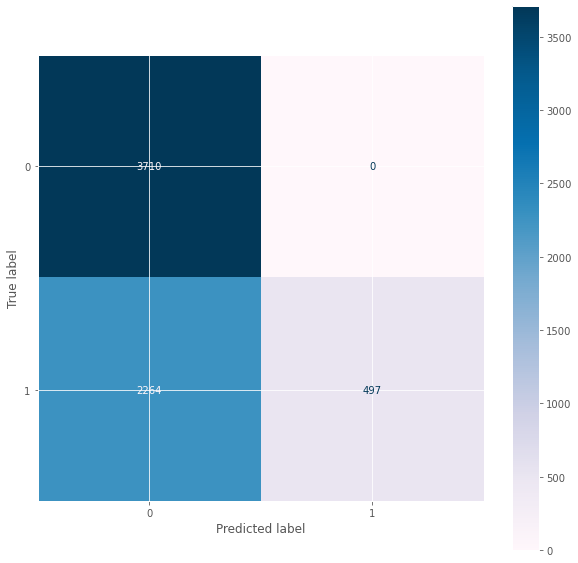

In [1066]:
report(rfbe, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.61      1.00      0.75       632
           1       1.00      0.19      0.32       510

    accuracy                           0.64      1142
   macro avg       0.80      0.60      0.54      1142
weighted avg       0.78      0.64      0.56      1142



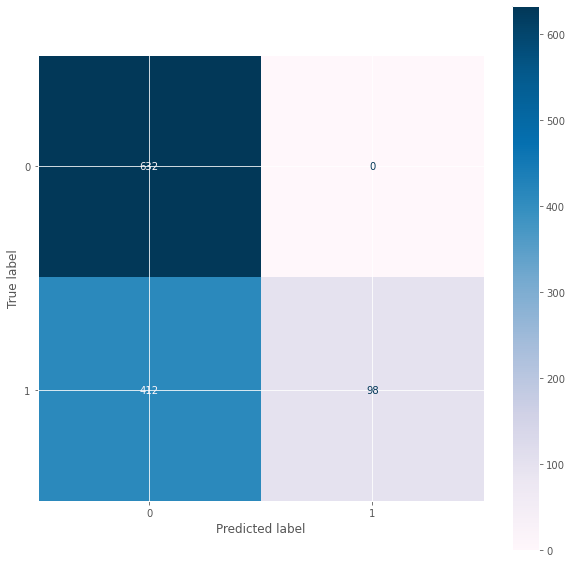

In [1067]:
report(rfbe, X_valid_tf, y_valid_tf)

In [1076]:
rf_val = rfbe.predict(X_valid_tf)
rf_pre = precision_score(y_valid_tf, rf_val)
rf_rec = recall_score(y_valid_tf, rf_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


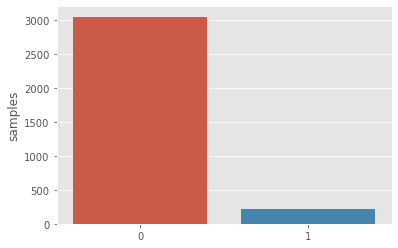

In [1247]:
rf_pred = rfbe.predict(tf_test)
rf_results = pd.DataFrame(y_id)
rf_results = rf_results.set_index('id')
rf_results['target'] = rf_pred

rf_res=rf_results.target.value_counts()
sns.barplot(rf_res.index,rf_res)
plt.gca().set_ylabel('samples')

rf_results.to_csv('rf.csv') # 0.

## SVM Classifiers

### Linear Kernel

In [1024]:
svml = SVC(kernel="linear", random_state=12, probability=True) # Linear Kernel

param_grid = {'C':np.arange(0.01,10.1,0.2)}

# Create gridsearch object with various combinations of parameters
svml_grid = GridSearchCV(svml, param_grid, cv = 5, n_jobs=-1)
svml_grid_fit = svml_grid.fit(X_train_tf, y_train_tf)

In [1025]:
svmlbf = svml_grid_fit.best_estimator_
print(svmlbf)

SVC(C=0.81, kernel='linear', probability=True, random_state=12)


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3710
           1       0.96      0.85      0.90      2761

    accuracy                           0.92      6471
   macro avg       0.93      0.91      0.91      6471
weighted avg       0.92      0.92      0.92      6471



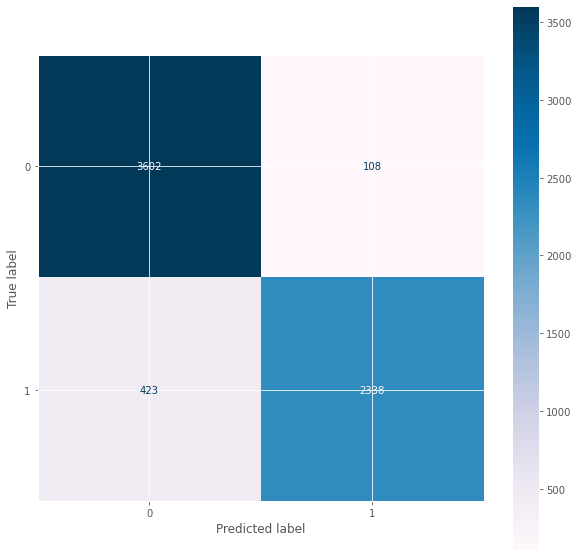

In [1114]:
report(svmlbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       632
           1       0.85      0.70      0.77       510

    accuracy                           0.81      1142
   macro avg       0.82      0.80      0.80      1142
weighted avg       0.82      0.81      0.81      1142



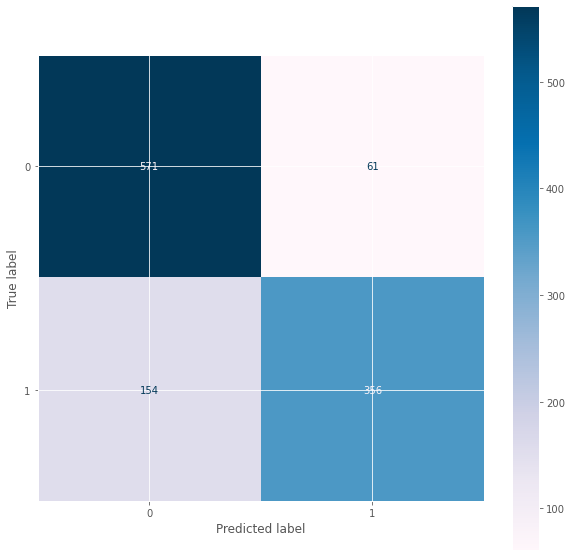

In [1113]:
report(svmlbf, X_valid_tf, y_valid_tf)

In [1075]:
lin_val = svmlbf.predict(X_valid_tf)
lin_pre = precision_score(y_valid_tf, lin_val)
lin_rec = recall_score(y_valid_tf, lin_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


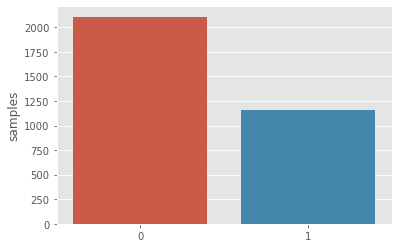

In [1246]:
svml_pred = svmlbf.predict(tf_test)
svml_results = pd.DataFrame(y_id)
svml_results = svml_results.set_index('id')
svml_results['target'] = svml_pred

svml_res = svml_results.target.value_counts()
sns.barplot(svml_res.index,svml_res)
plt.gca().set_ylabel('samples')

svml_results.to_csv('svm_linear.csv') # 0.79589

### Poly Kernel

In [1027]:
svmp = SVC(kernel="poly", random_state=12, probability=True) # Poly Kernel 

param_grid = {'C':np.arange(0.01,10.1,0.2),
             'degree':[2,3,4,5,6]}

# Create gridsearch object with various combinations of parameters
svmp_grid = GridSearchCV(svmp, param_grid, cv = 5, n_jobs=-1)
svmp_grid_fit = svmp_grid.fit(X_train_tf, y_train_tf)

In [1028]:
svmpbf = svmp_grid_fit.best_estimator_
print(svmpbf)

SVC(C=1.4100000000000001, degree=2, kernel='poly', probability=True,
    random_state=12)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3710
           1       0.99      0.97      0.98      2761

    accuracy                           0.98      6471
   macro avg       0.98      0.98      0.98      6471
weighted avg       0.98      0.98      0.98      6471



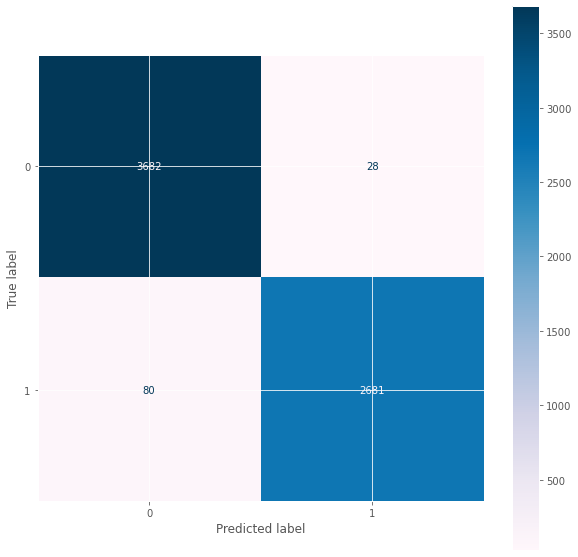

In [1029]:
report(svmpbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       632
           1       0.92      0.58      0.71       510

    accuracy                           0.79      1142
   macro avg       0.83      0.77      0.77      1142
weighted avg       0.82      0.79      0.78      1142



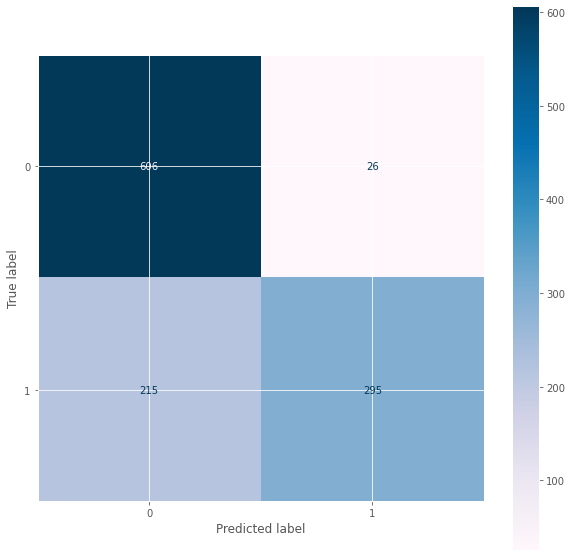

In [1046]:
report(svmpbf, X_valid_tf, y_valid_tf)

In [1074]:
poly_val = svmpbf.predict(X_valid_tf)
poly_pre = precision_score(y_valid_tf, poly_val)
poly_rec = recall_score(y_valid_tf, poly_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


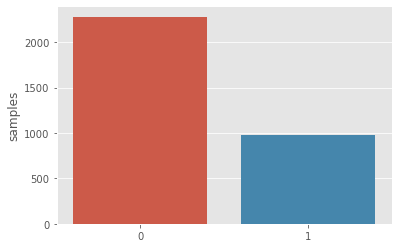

In [1245]:
svmpbf_pred = svmpbf.predict(tf_test)
svmpbf_results = pd.DataFrame(y_id)
svmpbf_results = svmpbf_results.set_index('id')
svmpbf_results['target'] = svmpbf_pred

svmpbf_res = svmpbf_results.target.value_counts()
sns.barplot(svmpbf_res.index,svmpbf_res)
plt.gca().set_ylabel('samples')

svmpbf_results.to_csv('svm_poly.csv') #.79405

### RBF Kernel

In [1030]:
svmrbf = SVC(kernel="rbf", random_state=12, probability=True) # RBF Kernel 

param_grid = {'C':np.arange(0.01,11,0.2),
             'gamma':[0.01,0.1,1,10,100]}

# Create gridsearch object with various combinations of parameters
svmrbf_grid = GridSearchCV(svmrbf, param_grid, cv = 5, n_jobs=-1)
svmrbf_grid_fit = svmrbf_grid.fit(X_train_tf, y_train_tf)

In [1031]:
svmrbf = svmrbf_grid_fit.best_estimator_
print(svmrbf)

SVC(C=5.01, gamma=0.1, probability=True, random_state=12)


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3710
           1       0.96      0.88      0.92      2761

    accuracy                           0.93      6471
   macro avg       0.94      0.93      0.93      6471
weighted avg       0.93      0.93      0.93      6471



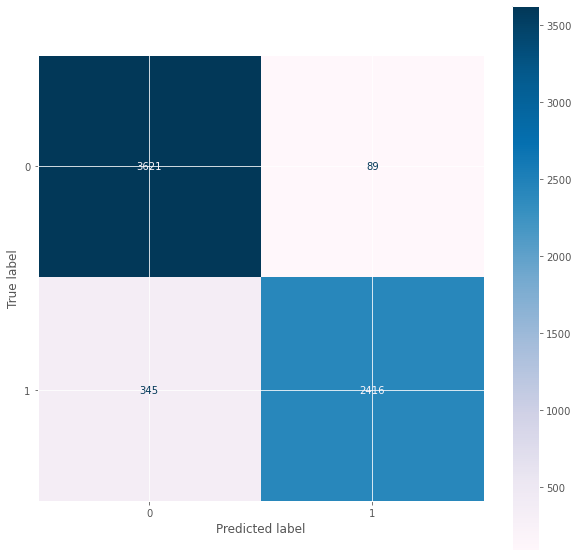

In [1032]:
report(svmrbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       632
           1       0.85      0.70      0.77       510

    accuracy                           0.81      1142
   macro avg       0.82      0.80      0.81      1142
weighted avg       0.82      0.81      0.81      1142



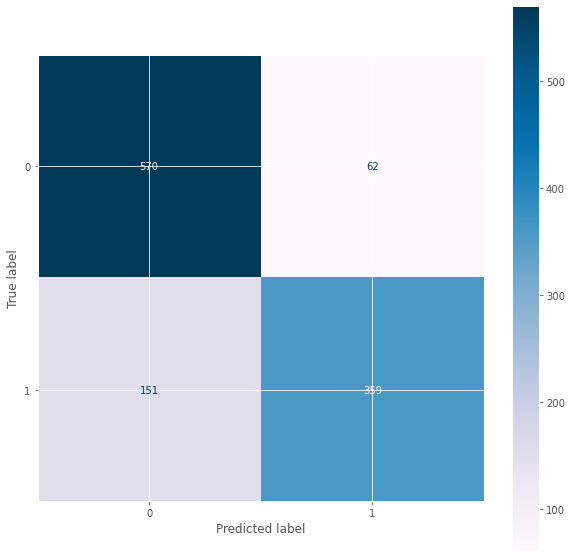

In [1047]:
report(svmrbf, X_valid_tf, y_valid_tf)

In [1073]:
rbf_val = svmrbf.predict(X_valid_tf)
rbf_pre = precision_score(y_valid_tf, rbf_val)
rbf_rec = recall_score(y_valid_tf, rbf_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

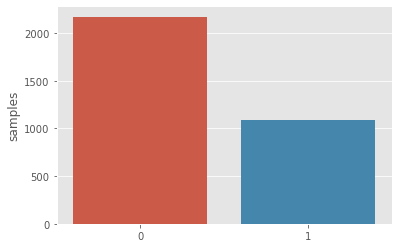

In [205]:
svmrbf_pred = svmrbf.predict(tf_test)
svmrbf_results = pd.DataFrame(y_id)
svmrbf_results = svmrbf_results.set_index('id')
svmrbf_results['target'] = svmrbf_pred

svmrbf_res = svmrbf_results.target.value_counts()
sns.barplot(svmrbf_res.index,svmrbf_res)
plt.gca().set_ylabel('samples')

svmrbf_results.to_csv('svm_rbf.csv') # 0.80876 accuracy on test 

## AdaBoost Classifier

In [1033]:
ab = AdaBoostClassifier(random_state=13)
#create a dictionary of parameters 
param_grid = {'n_estimators':[100,200,300,400],
              'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2]
             }

# Create gridsearch object with various combinations of parameters
ab_grid = GridSearchCV(ab, param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 5)
ab_grid_fit = ab_grid.fit(X_train_tf, y_train_tf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.9min finished


In [1034]:
abbf = ab_grid.best_estimator_
print(abbf)

AdaBoostClassifier(learning_rate=0.2, n_estimators=400, random_state=13)


              precision    recall  f1-score   support

           0       0.78      0.96      0.86      3710
           1       0.92      0.63      0.75      2761

    accuracy                           0.82      6471
   macro avg       0.85      0.79      0.80      6471
weighted avg       0.84      0.82      0.81      6471



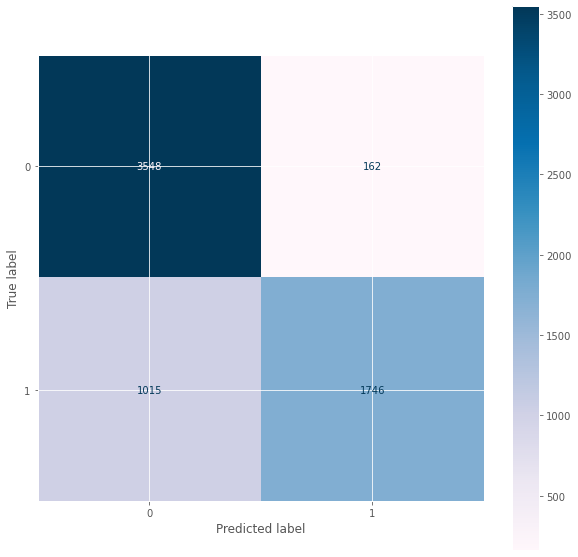

In [1035]:
report(abbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.74      0.93      0.82       632
           1       0.87      0.59      0.70       510

    accuracy                           0.78      1142
   macro avg       0.81      0.76      0.76      1142
weighted avg       0.80      0.78      0.77      1142



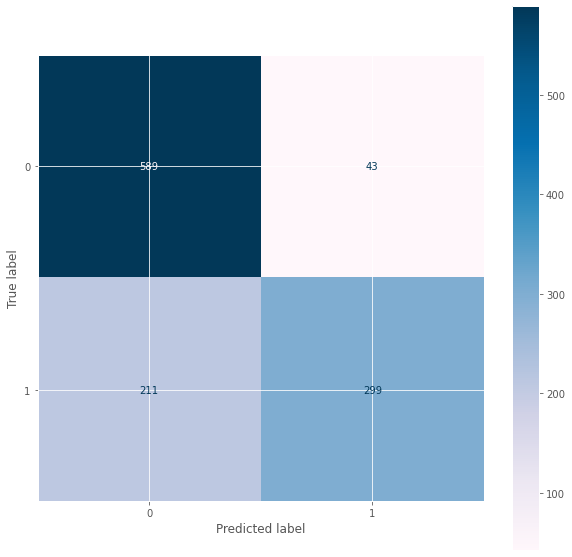

In [1048]:
report(abbf,X_valid_tf, y_valid_tf)

In [1072]:
ab_val = abbf.predict(X_valid_tf)
ab_pre = precision_score(y_valid_tf, ab_val)
ab_rec = recall_score(y_valid_tf, ab_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

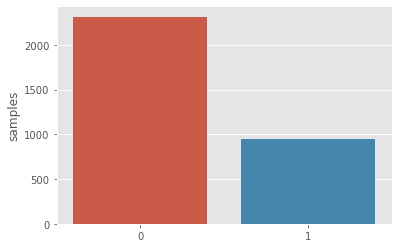

In [1145]:
abbf_pred = abbf.predict(tf_test)
abbf_results = pd.DataFrame(y_id)
abbf_results = abbf_results.set_index('id')
abbf_results['target'] = abbf_pred

abbf_res = abbf_results.target.value_counts()
sns.barplot(abbf_res.index,abbf_res)
plt.gca().set_ylabel('samples')

In [1146]:
abbf_results

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [1147]:
abbf_results.to_csv('adaboost.csv') #  accuracy on test 

## Gradient Boosting Classifier

In [1036]:
gb = GradientBoostingClassifier(random_state=13)

param_grid = {'n_estimators':[100,200,300,400],
              'learning_rate':[0.2,0.6,1],
              'max_depth':[1,2]
             }

gb_grid = GridSearchCV(gb, param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 5)
gb_grid_fit = gb_grid.fit(X_train_tf, y_train_tf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.8min finished


In [1037]:
gbbf = gb_grid.best_estimator_
print(gbbf)

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=400,
                           random_state=13)


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3710
           1       0.94      0.72      0.82      2761

    accuracy                           0.86      6471
   macro avg       0.88      0.84      0.85      6471
weighted avg       0.87      0.86      0.86      6471



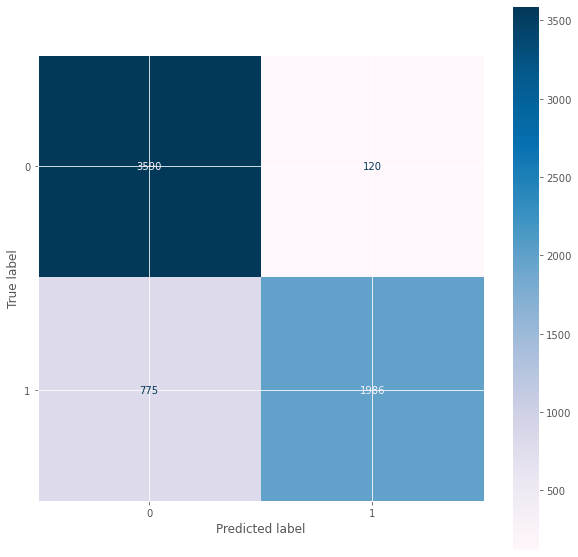

In [1038]:
report(gbbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       632
           1       0.86      0.65      0.74       510

    accuracy                           0.80      1142
   macro avg       0.81      0.78      0.79      1142
weighted avg       0.81      0.80      0.79      1142



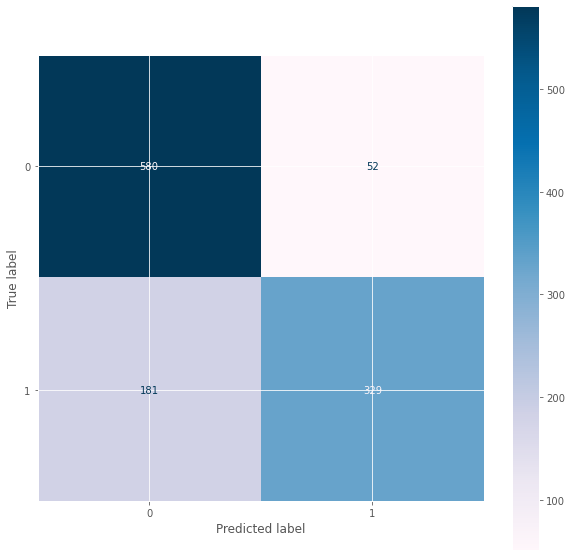

In [1049]:
report(gbbf,X_valid_tf, y_valid_tf)

In [1071]:
gb_val = gbbf.predict(X_valid_tf)
gb_pre = precision_score(y_valid_tf, gb_val)
gb_rec = recall_score(y_valid_tf, gb_val)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

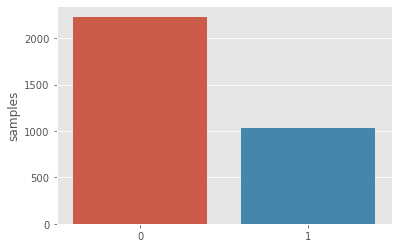

In [1149]:
gbbf_pred = gbbf.predict(tf_test)
gbbf_results = pd.DataFrame(y_id)
gbbf_results = gbbf_results.set_index('id')
gbbf_results['target'] = gbbf_pred

gbbf_res = gbbf_results.target.value_counts()
sns.barplot(gbbf_res.index,gbbf_res)
plt.gca().set_ylabel('samples')

In [1150]:
gbbf_results.to_csv('gradient.csv') #  0.77566 accuracy on test 

## XGBoost Classifier

In [1039]:
xgb = XGBClassifier()

params = {'n_estimators':np.arange(100,1050,50),
          'learning_rate':np.arange(0.1,1.7,0.1),
          'max_depth':[1,2],
          'gamma':np.arange(0,5.25,0.25)
         }

rs = RandomizedSearchCV(xgb,
                        param_distributions=params,
                        #n_iter=param_comb,
                        scoring='roc_auc', 
                        n_jobs=-1, 
                        cv=5, 
                        #verbose=3, 
                        random_state=12)

xgbrs = rs.fit(X_train_tf, y_train_tf)

In [1040]:
xgbf = xgbrs.best_estimator_
print(xgbf)

XGBClassifier(gamma=1.5, learning_rate=0.2, max_depth=2, n_estimators=550)


              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3710
           1       0.92      0.72      0.81      2761

    accuracy                           0.85      6471
   macro avg       0.87      0.84      0.84      6471
weighted avg       0.86      0.85      0.85      6471



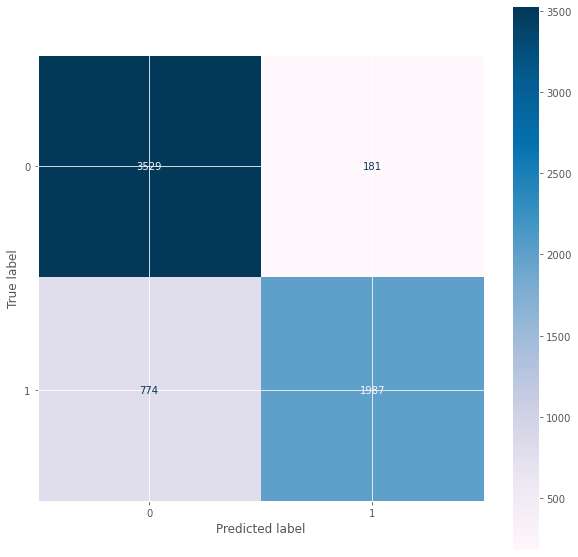

In [1050]:
report(xgbf, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       632
           1       0.86      0.65      0.74       510

    accuracy                           0.79      1142
   macro avg       0.81      0.78      0.78      1142
weighted avg       0.80      0.79      0.79      1142



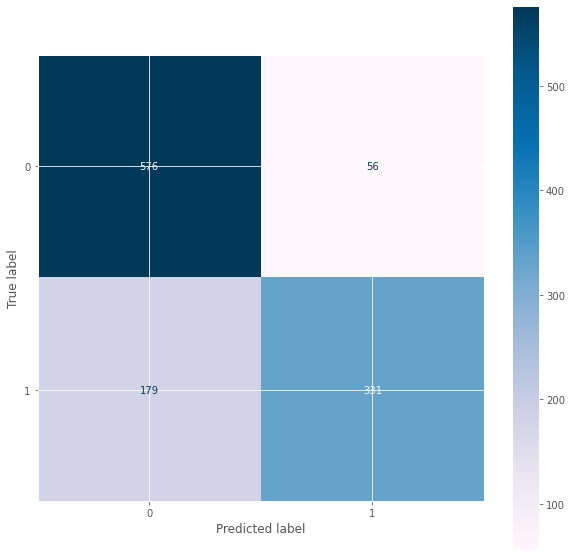

In [1051]:
report(xgbf, X_valid_tf, y_valid_tf)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

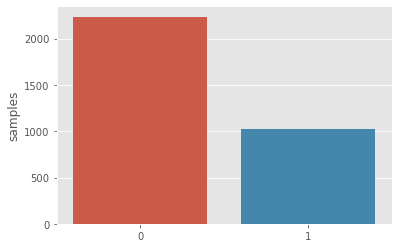

In [1251]:
xgbf_pred = xgbf.predict(tf_test)
xg_results = pd.DataFrame(y_id)
xg_results = xg_results.set_index('id')
xg_results['target'] = xgbf_pred

xgbf_res = xg_results.target.value_counts()
sns.barplot(xgbf_res.index,xgbf_res)
plt.gca().set_ylabel('samples')

In [1070]:
xg_val = xgbf.predict(X_valid_tf)
xg_pre = precision_score(y_valid_tf, xg_val)
xg_rec = recall_score(y_valid_tf, xg_val)

In [1129]:
xg_results.to_csv('xgboost.csv') # 0.78455 accuracy on test 

## Logistic Regression

In [1052]:
logc = LogisticRegression(random_state=0)
log_fit = logc.fit(tf_train, y_train)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3710
           1       0.94      0.77      0.85      2761

    accuracy                           0.88      6471
   macro avg       0.90      0.87      0.88      6471
weighted avg       0.89      0.88      0.88      6471



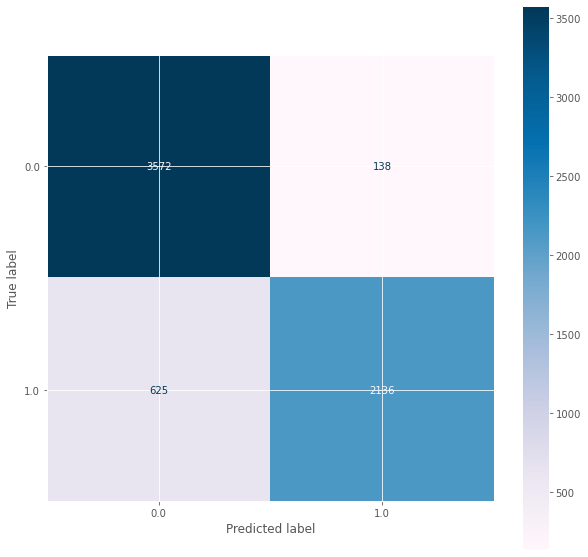

In [1053]:
report(logc, X_train_tf, y_train_tf)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       632
           1       0.96      0.81      0.88       510

    accuracy                           0.90      1142
   macro avg       0.91      0.89      0.90      1142
weighted avg       0.91      0.90      0.90      1142



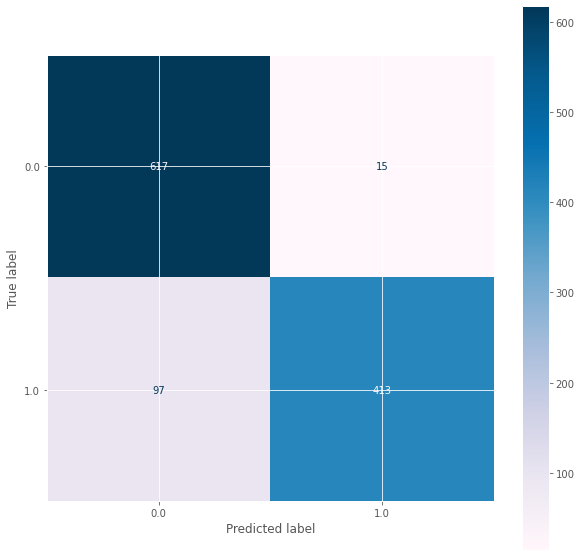

In [1055]:
report(logc, X_valid_tf, y_valid_tf)

In [1058]:
len(log_pred)

6471

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

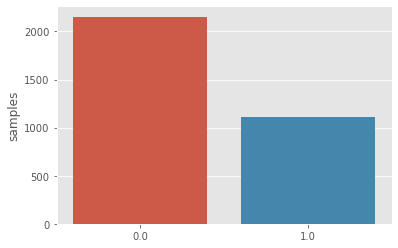

In [1154]:
log_pred = log_fit.predict(tf_test)
log_results = pd.DataFrame(y_id)
log_results['target'] = log_pred
log_results = log_results.set_index('id')

log_res = log_results.target.value_counts()
sns.barplot(log_res.index, log_res)
plt.gca().set_ylabel('samples')

In [1134]:
log_val = log_fit.predict(X_valid_tf)
log_pre = precision_score(y_valid_tf, log_val)
log_rec = recall_score(y_valid_tf, log_val)

In [1156]:
log_results

,target
id,
0,1.0
2,1.0
3,1.0
9,1.0
11,1.0
...,...
10861,1.0
10865,1.0
10868,1.0


In [1157]:
log_results.to_csv('logistic.csv') #0.79681 test accuracy 

### Logistic Regression with Added Predictors

In [591]:
df['bow'] = df['text'].map(str) + ' ' + df['location'].map(str) + ' ' + df['keyword'].map(str)

In [592]:
train_2 = df.iloc[:7613]
test_2 = df.iloc[7613:]

In [594]:
vectorizer = TfidfVectorizer()
tf2_train = vectorizer.fit_transform(train_2['bow'])
tf2_test = vectorizer.transform(test_2['bow'])

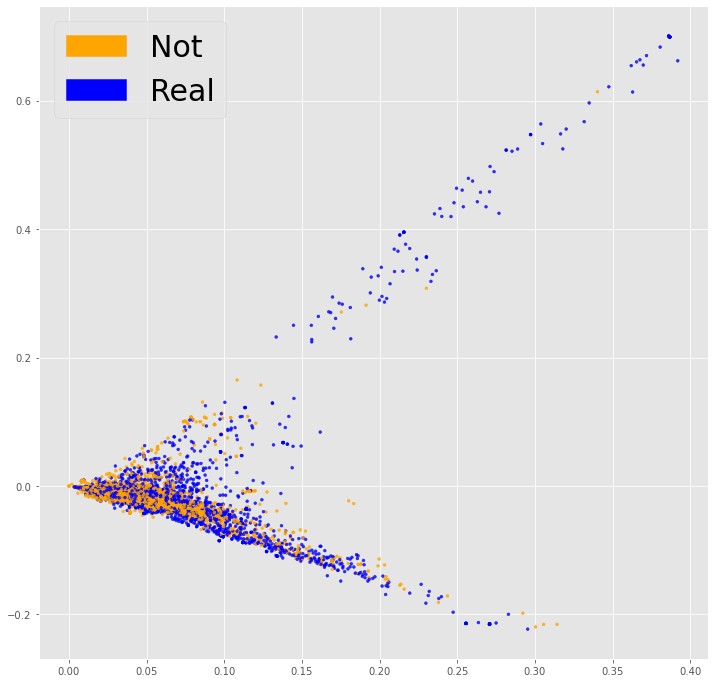

In [596]:
fig = plt.figure(figsize=(12, 12))          
plot_LSA(tf2_train, y_train)
plt.show()

In [556]:
log_bow = LogisticRegression(random_state=0)
log_bow_fit = log_bow.fit(tf2_train, y_train)
log_bow_pred = log_bow_fit.predict(tf2_test)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4342
           1       0.93      0.78      0.85      3271

    accuracy                           0.88      7613
   macro avg       0.89      0.87      0.88      7613
weighted avg       0.89      0.88      0.88      7613



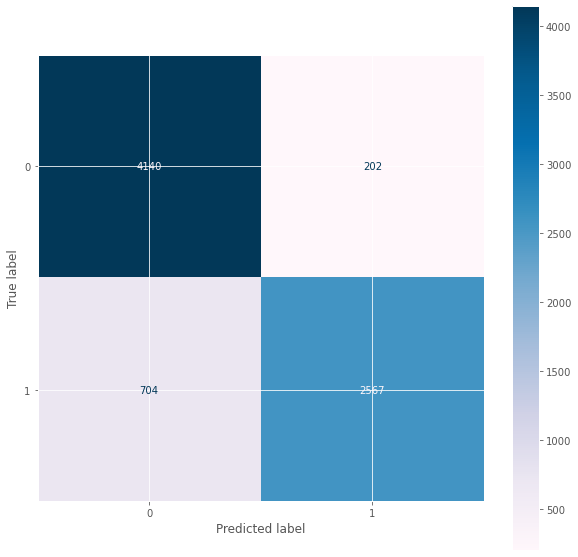

In [557]:
report(log_bow, tf2_train, y_train)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

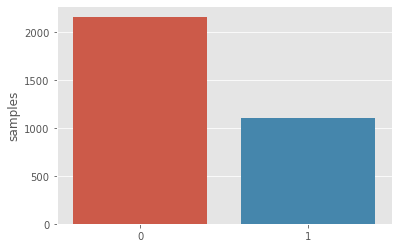

In [559]:
log_bow_results = pd.DataFrame(y_id)
log_bow_results['target'] = log_bow_pred
log_bow_results = log_bow_results.set_index('id')


log_bow_res = log_bow_results.target.value_counts()
sns.barplot(log_bow_res.index, log_res)
plt.gca().set_ylabel('samples')

In [560]:
log_bow_res

0    2078
1    1185
Name: target, dtype: int64

In [562]:
log_bow_results.to_csv('logistic_bow.csv') #  .789test accuracy 

## Ensemble

In [187]:
class_results = pd.DataFrame(rf_pred)

In [188]:
class_results = class_results.rename(columns={0:'Random Forest'})

In [946]:
class_results['Random Forest'] = rf_pred
class_results['SVM Linear'] = svml_pred
class_results['SVM Poly'] = svmpbf_pred
class_results['SVM RBF'] = svmrbf_pred
class_results['AdaBoost'] = abbf_pred
class_results['Gradient'] = gbbf_pred
class_results['XGBoost'] = xgbf_pred
class_results['Logistic'] = log_pred

In [947]:
class_results.sum(axis=0)

Random Forest     168.0
SVM Linear       1030.0
SVM Poly         1012.0
SVM RBF          1092.0
AdaBoost          843.0
Gradient          914.0
XGBoost          1093.0
Logistic         1110.0
dtype: float64

In [191]:
class_results[class_results.sum(axis=1)>=1]

,Random Forest,SVM Linear,SVM Poly,SVM RBF,AdaBoost,Gradient,XGBoost,Logistic
0,0,1,1,1,0,0,0,1
1,0,0,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
3258,0,1,1,1,1,1,1,1
3259,0,1,1,1,0,0,1,1
3260,0,1,1,1,1,1,1,1
3261,0,1,1,1,0,0,1,1


In [219]:
ensemb = VotingClassifier(estimators=[#('rf', rfbe),
                                      ('log', logc), 
                                      ('svm-linear', svmlbf), 
                                      ('svm-poly', svmpbf),
                                      ('svm-rbf', svmrbf),
                                      ('AdaBoost', abbf),
                                      ('Gradient', gbbf),
                                      ('XGBoost', xgbf)], 
                          voting='hard', 
                          n_jobs=-1)

ensemb_fit = ensemb.fit(tf_train, y_train)
ensemb_pred = ensemb_fit.predict(tf_test)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4342
           1       0.96      0.77      0.86      3271

    accuracy                           0.89      7613
   macro avg       0.91      0.87      0.88      7613
weighted avg       0.90      0.89      0.89      7613



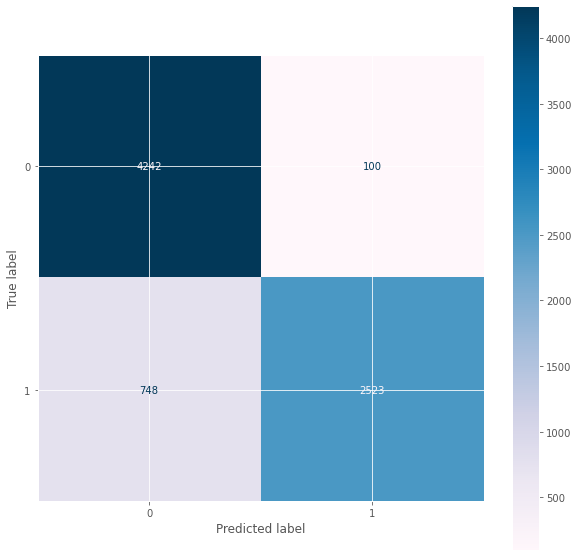

In [221]:
report(ensemb, tf_train, y_train) #96% weighted accuracy for soft voting
# 90% weighted average for hard voting 

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

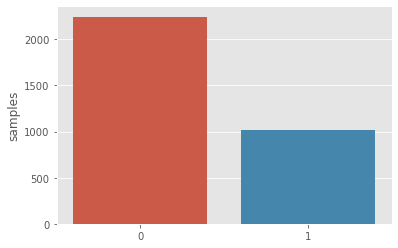

In [222]:
ensemb_results = pd.DataFrame(y_id)
ensemb_results['target'] = ensemb_pred
ensemb_results = ensemb_results.set_index('id')

en_res = ensemb_results.target.value_counts()
sns.barplot(en_res.index,en_res)
plt.gca().set_ylabel('samples')

In [218]:
ensemb_results.to_csv("ensemble.csv") #79.9957% acurracy for hard voting, 80.386% for soft 

In [1090]:
label = ['Logistic', 'XGBoost', 'Gradient Boost', 'AdaBoost','SVM RBF', 'SVM Poly', 'SVM Linear','Random Forest']
rec_scores = [log_rec, xg_rec, gb_rec, ab_rec, rbf_rec, poly_rec, lin_rec, rf_rec]
prec_scores = [log_pre, xg_pre, gb_pre, ab_pre, rbf_pre, poly_pre, lin_pre, rf_pre]

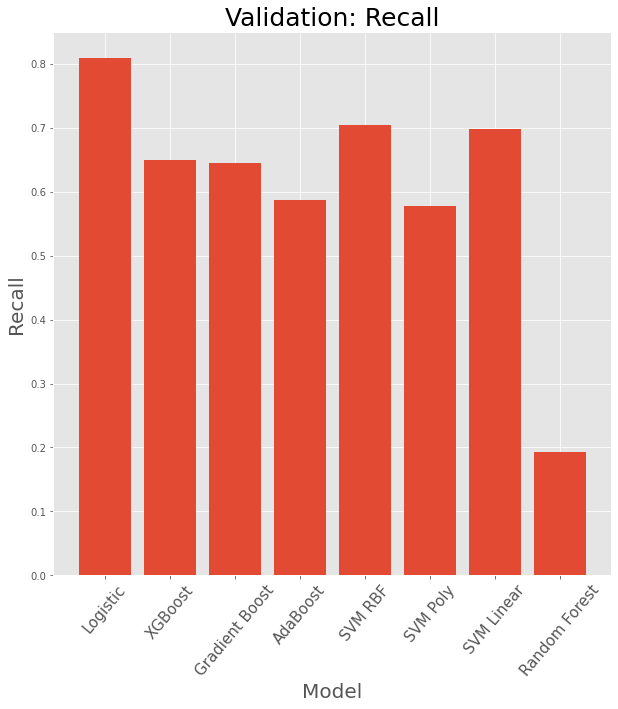

In [1121]:
index = np.arange(len(label))
plt.figure(figsize=(10,10))
plt.bar(index, rec_scores)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Recall', fontsize=20)
plt.xticks(index, label, fontsize=15, rotation=50)
plt.title('Validation: Recall', fontsize=25)
plt.show()

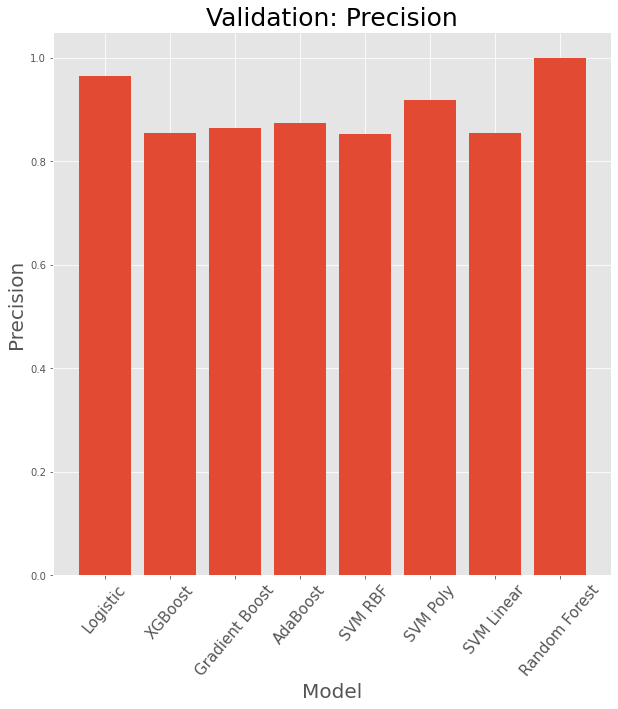

In [1122]:
index = np.arange(len(label))
plt.figure(figsize=(10,10))
plt.bar(index, prec_scores)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(index, label, fontsize=15, rotation=50)
plt.title('Validation: Precision', fontsize=25)
plt.show()

# Glove Vectorization 

In [948]:
train = df.iloc[:7613]
test = df.iloc[7613:]

In [949]:
train['target'] = train['target'].astype(int)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [950]:
os.chdir('/Users/kylaronellenfitsch/glove.6B')

In [951]:
embedding_dict = {} #First load glove vectors 
with open('/Users/kylaronellenfitsch/glove.6B/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [952]:
os.chdir('/Users/kylaronellenfitsch/Documents/MScA/Machine Learning')

In [1224]:
corpus=[]

for tweet in df['text']:
    words=[word for word in word_tokenize(tweet)] 
    corpus.append(words)

In [1225]:
max_length = 100
#max_words = 10000

tokenizer = Tokenizer() #create tokenizer object
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

word_index = tokenizer.word_index
print('Unique words = {}'.format(len(word_index)))

Unique words = 19726


In [1226]:
tweet_pad = pad_sequences(sequences,
                          maxlen = max_length,
                          truncating = 'post',
                          padding = 'post')

In [1227]:
#Prepare embedding matrix 

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    #if i > max_words:
    #    continue
    
    embedding_vector = embedding_dict.get(word) #uses loaded glove embedding dictionary
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [1228]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000
1,-0.26872,-0.15542,-0.235650,-0.035982,-0.399060,0.522880,0.612850,0.424280,0.31335,0.436890,...,0.704640,-0.66008,-0.628590,0.943200,-0.75674,0.359790,-0.23791,0.49344,0.721140,-0.041749
2,-0.26870,0.81708,0.698960,-0.723410,0.091566,0.195570,-0.521120,-0.243130,-0.44701,-0.270390,...,0.205430,-0.46372,-0.065652,-0.061944,-0.57233,-0.464060,-0.41405,-0.40110,0.746570,0.311220
3,-0.44497,0.26160,-0.177850,-0.409140,-0.401700,0.054959,0.093679,0.069059,-0.78829,0.065775,...,0.203080,-0.33559,0.177300,-0.482490,-0.40054,0.293760,0.33946,-0.33028,0.581110,0.382050
4,0.41711,-0.10176,0.058147,-0.183320,-0.444580,-0.178520,-0.343920,-0.077147,0.58521,-0.527520,...,0.385960,0.59233,1.435500,1.456300,1.18010,0.329870,0.84998,-0.29444,-0.039114,0.395340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19722,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000
19723,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000
19724,0.75547,1.03650,0.102130,0.249560,0.025430,-0.572340,0.307120,-0.401100,0.44340,0.134380,...,0.040774,0.41585,-0.805220,0.134840,-0.93464,-0.077961,0.46672,-0.17503,-0.133420,0.145820
19725,0.14356,-0.72253,-0.017184,-0.981560,0.050448,-0.603450,-0.175320,-0.391710,0.45245,-0.185780,...,-0.453240,0.50957,-0.457090,-0.330970,0.28093,-0.370950,0.31136,-0.24946,0.376160,0.091572


# LSTM Model

In [959]:
train_text = tweet_pad[:train.shape[0]] # build train and validation test sets 
test_text = tweet_pad[train.shape[0]:]

X_train, X_valid, y_train, y_valid = train_test_split(train_text, train['target'].values, test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (6471, 100)
Shape of Validation  (1142, 100)


In [992]:
lstm1 = Sequential([
    Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_length, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

optimizer=Adam(learning_rate=1e-5)

lstm1.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = 'accuracy')

In [993]:
lstm1.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 100)          1972700   
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 100, 100)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 2,015,005
Trainable params: 42,305
Non-trainable params: 1,972,700
_________________________________________________________________


In [994]:
history=lstm1.fit(X_train, #fit model to train and validation sets 
                  y_train,
                  batch_size = 38,
                  epochs = 15,
                  validation_data = (X_valid, y_valid),
                  verbose = 2
                 )

Epoch 1/15
171/171 - 13s - loss: 0.6927 - accuracy: 0.5730 - val_loss: 0.6924 - val_accuracy: 0.5560
Epoch 2/15
171/171 - 13s - loss: 0.6915 - accuracy: 0.5729 - val_loss: 0.6914 - val_accuracy: 0.5560
Epoch 3/15
171/171 - 13s - loss: 0.6899 - accuracy: 0.5729 - val_loss: 0.6900 - val_accuracy: 0.5560
Epoch 4/15
171/171 - 14s - loss: 0.6876 - accuracy: 0.5729 - val_loss: 0.6880 - val_accuracy: 0.5560
Epoch 5/15
171/171 - 13s - loss: 0.6840 - accuracy: 0.5729 - val_loss: 0.6850 - val_accuracy: 0.5560
Epoch 6/15
171/171 - 13s - loss: 0.6670 - accuracy: 0.5729 - val_loss: 0.6484 - val_accuracy: 0.5560
Epoch 7/15
171/171 - 14s - loss: 0.6361 - accuracy: 0.5729 - val_loss: 0.6245 - val_accuracy: 0.5560
Epoch 8/15
171/171 - 13s - loss: 0.6139 - accuracy: 0.5732 - val_loss: 0.6104 - val_accuracy: 0.5622
Epoch 9/15
171/171 - 13s - loss: 0.6030 - accuracy: 0.6498 - val_loss: 0.5986 - val_accuracy: 0.7662
Epoch 10/15
171/171 - 13s - loss: 0.5939 - accuracy: 0.7453 - val_loss: 0.5872 - val_accura

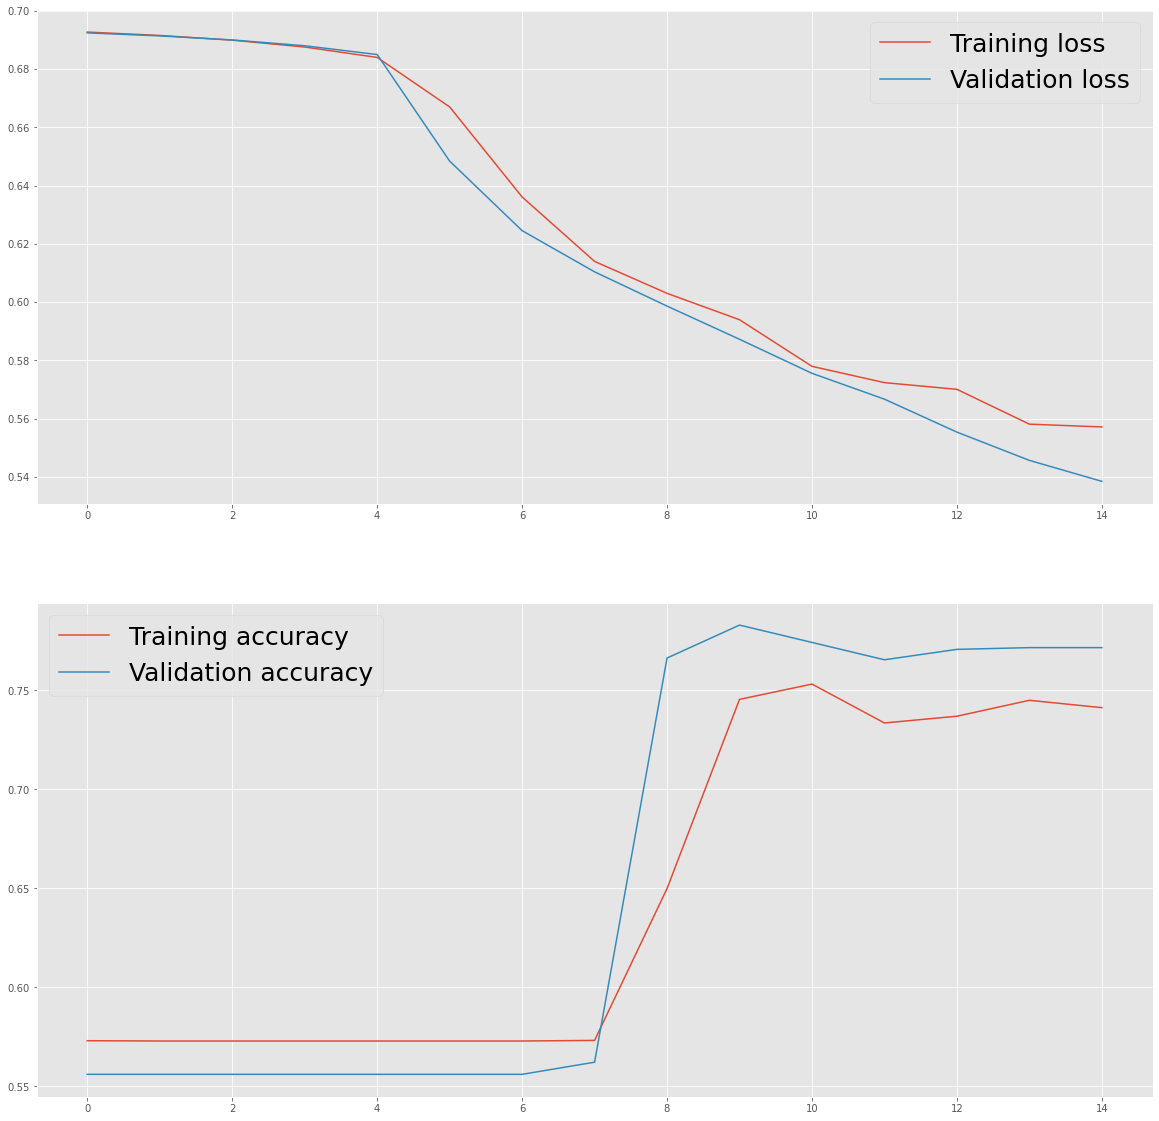

In [995]:
#training history

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'], label="Validation loss",)
legend = ax[0].legend(loc='best', fontsize=25)

ax[1].plot(history.history['accuracy'], label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
legend = ax[1].legend(loc='best', fontsize=25)

In [996]:
lstm1_pred = lstm1.predict(test_text) #predict on test set 
lstm1_pred = np.round(lstm1_pred).astype(int).reshape(3263)

lstm1_results = pd.DataFrame(y_id) #save results for submission to kaggle 
lstm1_results['target'] = lstm1_pred
lstm1_results = lstm1_results.set_index('id')

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

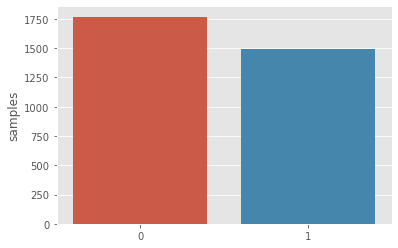

In [997]:
lstm1_res = lstm1_results.target.value_counts() #visualize results 
sns.barplot(lstm1_res.index,lstm1_res)
plt.gca().set_ylabel('samples')

In [998]:
lstm1_res #over-detected class 1

0    1768
1    1495
Name: target, dtype: int64

In [999]:
lstm1_results.to_csv('lstm1.csv') 
# .75 accuracy for epochs = 15, batch =100
# .7744 accuracy for epochs = 15, batch = 50
#.786 accuracy for epochs = 15, batch size = 38
#.7717 accuracy for epochs = 20, batch size = 38

In [1000]:
lstm1.save('lstm1.h5') #save model 
print("Saved model")

Saved model


In [1188]:
yy = df['target']
yy = y_train[:7613]

In [1190]:
lstm1_pred_val = lstm1.predict(train_text)
lstm1_pred_val = np.round(lstm1_pred_val).astype(int).reshape(7613)
print(classification_report(yy, lstm1_pred_val))  

#X_valid_tf, y_valid_tf)
    
#fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(model, x, y, cmap = 'PuBu', ax=ax)

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79      4342
         1.0       0.71      0.75      0.73      3271

    accuracy                           0.76      7613
   macro avg       0.76      0.76      0.76      7613
weighted avg       0.76      0.76      0.76      7613



In [1191]:
3271/4342

0.7533394748963611

In [1192]:
1495/1768

0.8455882352941176

# LSTM2

In [983]:
lstm2 = Sequential([
    Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_length, trainable=False),
    #SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

optimizer=Adam(learning_rate=1e-5)

lstm2.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = 'accuracy')

In [984]:
lstm2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 100)          1972700   
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 2,015,005
Trainable params: 42,305
Non-trainable params: 1,972,700
_________________________________________________________________


In [985]:
history=lstm2.fit(X_train, #fit model to train and validation sets 
                  y_train,
                  batch_size = 38,
                  epochs = 12,
                  validation_data = (X_valid, y_valid),
                  verbose = 2
                 )

Epoch 1/12
171/171 - 13s - loss: 0.6927 - accuracy: 0.5692 - val_loss: 0.6924 - val_accuracy: 0.5560
Epoch 2/12
171/171 - 12s - loss: 0.6916 - accuracy: 0.5729 - val_loss: 0.6914 - val_accuracy: 0.5560
Epoch 3/12
171/171 - 13s - loss: 0.6900 - accuracy: 0.5729 - val_loss: 0.6901 - val_accuracy: 0.5560
Epoch 4/12
171/171 - 14s - loss: 0.6879 - accuracy: 0.5729 - val_loss: 0.6884 - val_accuracy: 0.5560
Epoch 5/12
171/171 - 12s - loss: 0.6853 - accuracy: 0.5729 - val_loss: 0.6870 - val_accuracy: 0.5560
Epoch 6/12
171/171 - 13s - loss: 0.6829 - accuracy: 0.5729 - val_loss: 0.6861 - val_accuracy: 0.5560
Epoch 7/12
171/171 - 12s - loss: 0.6762 - accuracy: 0.5729 - val_loss: 0.6668 - val_accuracy: 0.5560
Epoch 8/12
171/171 - 13s - loss: 0.6380 - accuracy: 0.5729 - val_loss: 0.6387 - val_accuracy: 0.5560
Epoch 9/12
171/171 - 13s - loss: 0.6129 - accuracy: 0.5729 - val_loss: 0.6182 - val_accuracy: 0.5560
Epoch 10/12
171/171 - 13s - loss: 0.5981 - accuracy: 0.6413 - val_loss: 0.6053 - val_accura

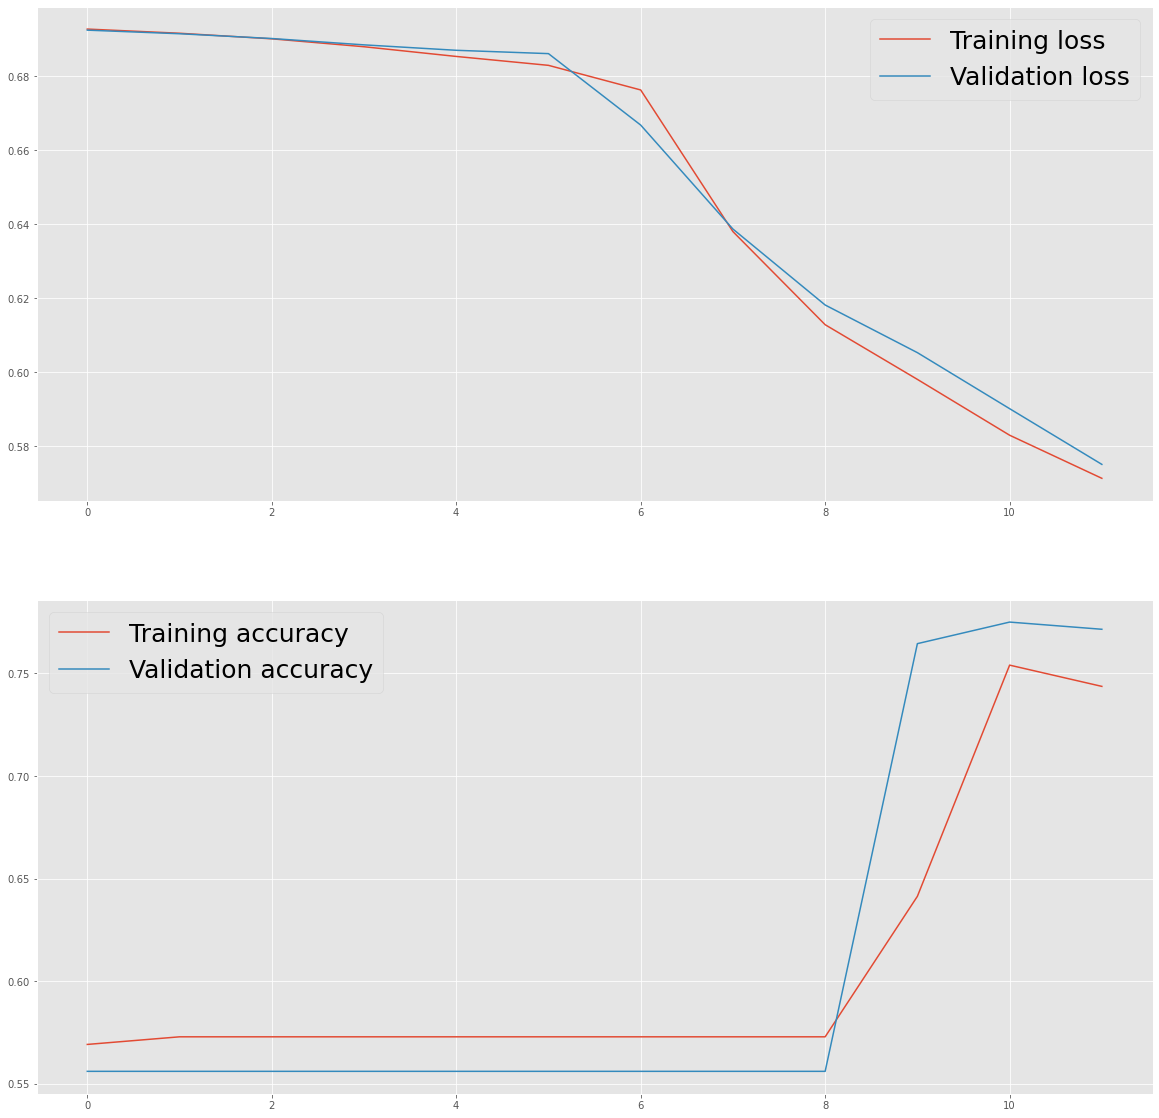

In [986]:
#training history

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'], label="Validation loss",)
legend = ax[0].legend(loc='best', fontsize=25)

ax[1].plot(history.history['accuracy'], label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
legend = ax[1].legend(loc='best', fontsize=25)

In [988]:
lstm2_pred = lstm2.predict(test_text) #predict on test set 
lstm2_pred = np.round(lstm2_pred).astype(int).reshape(3263)

lstm2_results = pd.DataFrame(y_id) #save results for submission to kaggle 
lstm2_results['target'] = lstm2_pred
lstm2_results = lstm2_results.set_index('id')

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

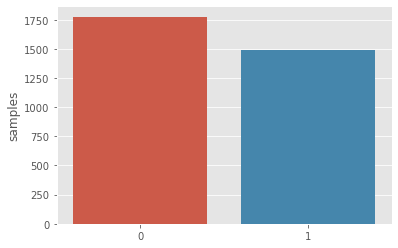

In [989]:
lstm2_res = lstm2_results.target.value_counts() #visualize results 
sns.barplot(lstm2_res.index,lstm2_res)
plt.gca().set_ylabel('samples')

In [990]:
lstm2_results.to_csv('lstm2.csv') #73% accuracy 

In [991]:
lstm2.save('lstm2.h5') #save model 
print("Saved model")

Saved model


# LSTM with Additional Features

Didn't finish this

In [1198]:
df = df.fillna('')
df['keyword'] = df['keyword'].astype('string')
df['location'] = df['location'].astype('string')

In [1234]:
corpus_kw = []

for tweet in df['keyword']:
    words=[word for word in word_tokenize(tweet)] 
    corpus_kw.append(words)
    
max_length_kw = 2
#max_words = 10000

tokenizer_kw = Tokenizer() #create tokenizer object
tokenizer.fit_on_texts(corpus_kw)
sequences_kw = tokenizer_kw.texts_to_sequences(corpus_kw)

word_index_kw = tokenizer_kw.word_index
print('Unique words = {}'.format(len(word_index_kw)))

tweet_pad_kw = pad_sequences(sequences_kw,
                          maxlen = max_length_kw,
                          truncating = 'post',
                          padding = 'post')

#Prepare embedding matrix 

num_words_kw = len(word_index_kw) + 1
embedding_matrix_kw = np.zeros((num_words_kw, 100))

for word, i in word_index_kw.items():

    embedding_vector_kw = embedding_dict.get(word) #uses loaded glove embedding dictionary
    if embedding_vector_kw is not None:
        embedding_matrix_kw[i] = embedding_vector_kw
        
train_text_kw = tweet_pad_kw[:train.shape[0]] # build train and validation test sets 
test_text_kw = tweet_pad_kw[train.shape[0]:]

X_train_kw, X_valid_kw, y_train_kw, y_valid_kw = train_test_split(train_text_kw, train['target'].values, test_size=0.15)
print('Shape of train', X_train_kw.shape)
print("Shape of Validation ", X_valid_kw.shape)

Unique words = 0
Shape of train (6471, 2)
Shape of Validation  (1142, 2)


In [1235]:
corpus_loc = []

for tweet in df['location']:
    words=[word for word in word_tokenize(tweet)] 
    corpus_loc.append(words)
    
max_length_loc = 5
#max_words = 10000

tokenizer_loc = Tokenizer() #create tokenizer object
tokenizer.fit_on_texts(corpus_loc)
sequences_loc = tokenizer_loc.texts_to_sequences(corpus_loc)

word_index_loc = tokenizer_loc.word_index
print('Unique words = {}'.format(len(word_index_loc)))

tweet_pad_loc = pad_sequences(sequences_loc,
                          maxlen = max_length_loc,
                          truncating = 'post',
                          padding = 'post')

#Prepare embedding matrix 

num_words_loc = len(word_index_loc) + 1
embedding_matrix_loc = np.zeros((num_words_loc, 100))

for word, i in word_index_loc.items():

    embedding_vector_loc = embedding_dict.get(word) #uses loaded glove embedding dictionary
    if embedding_vector_loc is not None:
        embedding_matrix_loc[i] = embedding_vector_loc
        
train_text_loc = tweet_pad_loc[:train.shape[0]] # build train and validation test sets 
test_text_loc = tweet_pad_loc[train.shape[0]:]

X_train_loc, X_valid_loc, y_train_loc, y_valid_loc = train_test_split(train_text_loc, train['target'].values, test_size=0.15)
print('Shape of train', X_train_loc.shape)
print("Shape of Validation ", X_valid_loc.shape)

Unique words = 0
Shape of train (6471, 5)
Shape of Validation  (1142, 5)


In [1236]:
len(word_index)

19726

In [1243]:
input_text = Sequential([
    Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_length, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2)
    #Dense(1, activation='sigmoid')
    #Flatten()
])

input_keyword = Sequential([
    Embedding(num_words_kw, 100, embeddings_initializer=Constant(embedding_matrix_kw),
                   input_length=max_length_kw, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2)
    #Dense(1, activation='sigmoid')
    #Flatten()
])

input_location = Sequential([
    Embedding(num_words_loc, 100, embeddings_initializer=Constant(embedding_matrix_loc),
                   input_length=max_length_loc, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2,  recurrent_dropout=0.2)
    #Flatten()
])

merge = Concatenate([input_text, input_keyword, input_location])

In [1248]:
#dense = Dense(1, activation='sigmoid')(merge)

In [ ]:
optimizer=Adam(learning_rate=1e-5)

lstm_combo.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = 'accuracy')